In [9]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt


In [3]:
#shapefile_parcels = gpd.read_file('zip:///Users/jameskreft/AnacondaProjects/madison_parcels_data/Tax_Parcels_shapefile_2022_02_15.zip')


In [4]:
#shapefile_parcels.info(verbose=True)

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 80472 entries, 0 to 80471
Data columns (total 143 columns):
 #    Column      Dtype   
---   ------      -----   
 0    OBJECTID    int64   
 1    Parcel      object  
 2    XRefParcel  object  
 3    Address     object  
 4    DateParcel  object  
 5    PropertyCl  object  
 6    PropertyUs  object  
 7    Assessment  int64   
 8    AreaName    object  
 9    MoreThanOn  object  
 10   HomeStyle   object  
 11   YearBuilt   int64   
 12   Bedrooms    int64   
 13   FullBaths   int64   
 14   HalfBaths   int64   
 15   TotalLivin  int64   
 16   FirstFloor  int64   
 17   SecondFloo  int64   
 18   ThirdFloor  int64   
 19   AboveThird  int64   
 20   FinishedAt  int64   
 21   Basement    int64   
 22   FinishedBa  int64   
 23   ExteriorWa  object  
 24   Exterior_1  object  
 25   Fireplaces  int64   
 26   CentralAir  object  
 27   PartialAss  object  
 28   AssessedBy  object  
 29   CurrentLan  int64   
 30   CurrentImp  

In [6]:
parcels = gpd.read_file('Tax_Parcels_2022_02_15.geojson')


In [7]:
parcels.info(verbose=True)

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 80472 entries, 0 to 80471
Data columns (total 143 columns):
 #    Column                  Dtype   
---   ------                  -----   
 0    OBJECTID                int64   
 1    Parcel                  object  
 2    XRefParcel              object  
 3    Address                 object  
 4    DateParcelChanged       object  
 5    PropertyClass           object  
 6    PropertyUse             object  
 7    AssessmentArea          int64   
 8    AreaName                object  
 9    MoreThanOneBuild        object  
 10   HomeStyle               object  
 11   YearBuilt               int64   
 12   Bedrooms                int64   
 13   FullBaths               int64   
 14   HalfBaths               int64   
 15   TotalLivingArea         int64   
 16   FirstFloor              int64   
 17   SecondFloor             int64   
 18   ThirdFloor              int64   
 19   AboveThirdFloor         int64   
 20   FinishedAttic     

/var/folders/gl/n2yq1pcs0fj_6dw3z1sh7dkh0000gn/T/ipykernel_18687/279084073.py:11: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  parcels_grouped = parcels.groupby('PropertyUse')['TotalTaxes','LotSize'].sum()


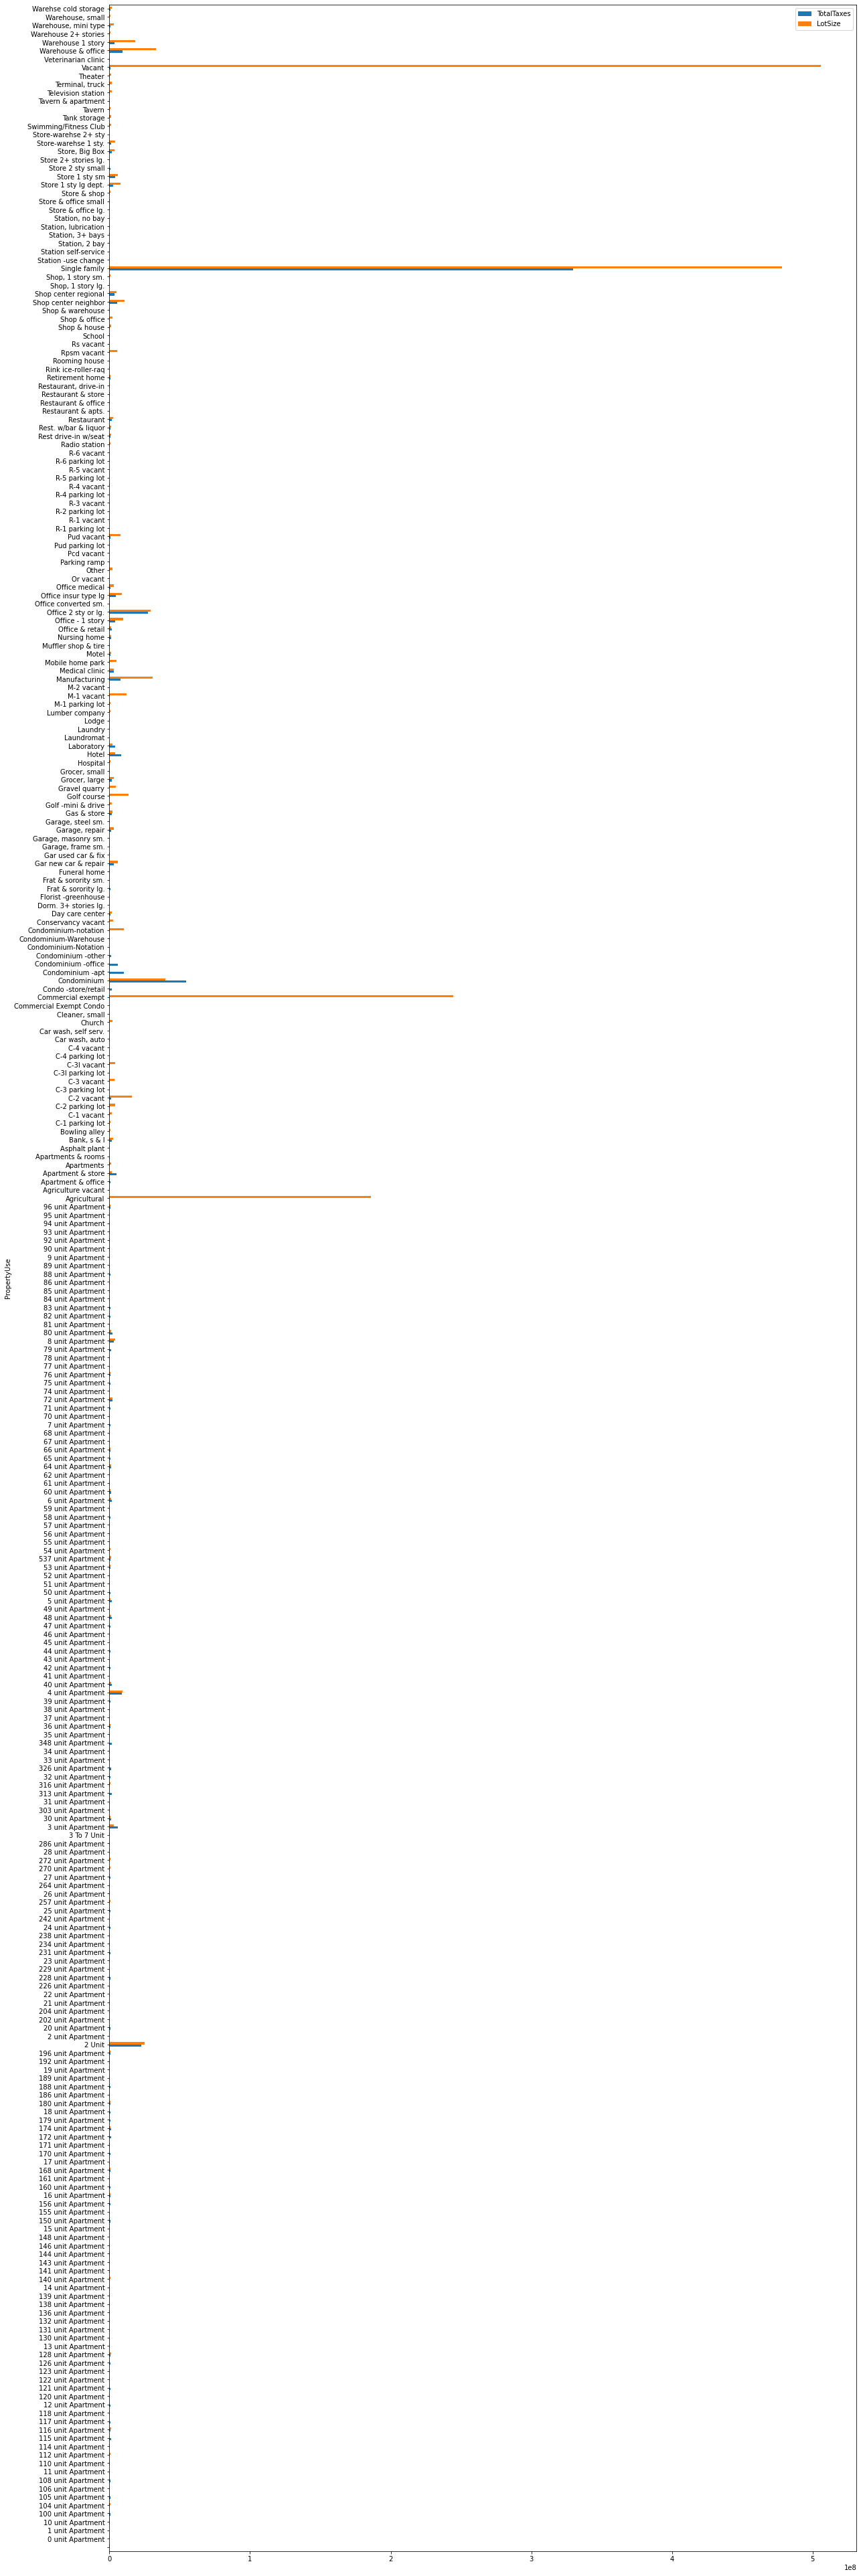

,TotalTaxes,LotSize
PropertyUse,,
,51208.69,286229.0
0 unit Apartment,50116.20,194958.0
1 unit Apartment,9051.17,17980.0
10 unit Apartment,558714.54,359870.1
100 unit Apartment,744863.31,502218.0


In [22]:
# groupby bat_team and get mean of runs

#dfg = df.groupby('bat_team')['runs'].mean()

# plot the groupby result
#ax = dfg.plot.bar(figsize=(20, 10), ylabel='Average Runs')
#plt.show()

def clean_up_property_use(prop_use):
    if prop_use.starts_with('Warehouse') or prop_use.starts_with('Warehse')
        cleaned_use = 'Warehouse'
    else if prop_use.starts_with('Store'):
        cleaned_use = 'Store'
    else if prop_use.starts_with('Station')
        cleaned_use = 'Station'


parcels_grouped = parcels.groupby('PropertyUse')['TotalTaxes','LotSize'].sum()

ax = parcels_grouped.plot.barh(figsize=(20, 70), ylabel='Total Taxes')

plt.show()

parcels_grouped.head()

In [14]:
narrowed_parcels = parcels.loc[:,['OBJECTID', 'Parcel', 'XRefParcel', 'Address', 'PropertyClass', 'PropertyUse',
                                  'AreaName', 'Bedrooms', 'CurrentTotal', 'NetTaxes', 'TotalTaxes', 'LotSize', 
                                  'Zoning1', 'LotDepth', 'LotWidth', 'LotType1', 'LotType2','Ward', 'AlderDistrict', 'TotalDwellingUnits','geometry']]


In [15]:
narrowed_parcels["MostCommonPropertyClass"] = (narrowed_parcels.groupby("XRefParcel")["PropertyClass"]
                        .transform(lambda x: x.value_counts().index[0]))

narrowed_parcels["MostCommonPropertyUse"] = (narrowed_parcels.groupby("XRefParcel")["PropertyUse"]
                        .transform(lambda x: x.value_counts().index[0]))

narrowed_parcels["MostCommonAreaName"] = (narrowed_parcels.groupby("XRefParcel")["AreaName"]
                        .transform(lambda x: x.value_counts().index[0]))

narrowed_parcels["MostCommonLotType1"] = (narrowed_parcels.groupby("XRefParcel")["LotType1"]
                        .transform(lambda x: x.value_counts().index[0]))

narrowed_parcels["MostCommonLotType2"] = (narrowed_parcels.groupby("XRefParcel")["LotType2"]
                        .transform(lambda x: x.value_counts().index[0]))

narrowed_parcels["MostCommonZoning1"] = (narrowed_parcels.groupby("XRefParcel")["Zoning1"]
                        .transform(lambda x: x.value_counts().index[0]))

narrowed_parcels_grouped = narrowed_parcels.groupby(["XRefParcel","geometry", "MostCommonPropertyClass", 
                  "MostCommonPropertyUse", "MostCommonAreaName", "MostCommonLotType1", "MostCommonLotType2", 
                  "MostCommonZoning1", "Ward", 'AlderDistrict'], sort=False, as_index=False).agg(
    {"Address":"min", "Bedrooms":"sum", "CurrentTotal":"sum", "NetTaxes":"sum","TotalTaxes":"sum", 
     "LotSize":"max","AreaName":"max", "TotalDwellingUnits":"sum"})

narrowed_parcels_grouped = gpd.GeoDataFrame(narrowed_parcels_grouped, geometry='geometry')

narrowed_parcels_grouped['taxes_per_sq_foot'] = narrowed_parcels_grouped['TotalTaxes']/narrowed_parcels_grouped['LotSize']
#narrowed_parcels_grouped.explore("taxes_per_sq_foot", cmap="Blues",tooltip=False, popup=True, tiles='Stamen Toner' )

In [16]:
#commenting this out for now, the city fixed this data issue
#narrowed_parcels_grouped.loc[narrowed_parcels_grouped["Address"].str.startswith('300 S Bedford', na=False)]

,XRefParcel,geometry,MostCommonPropertyClass,MostCommonPropertyUse,MostCommonAreaName,MostCommonLotType1,MostCommonLotType2,MostCommonZoning1,Ward,AlderDistrict,Address,Bedrooms,CurrentTotal,NetTaxes,TotalTaxes,LotSize,AreaName,TotalDwellingUnits,taxes_per_sq_foot
12566,070923403095,"POLYGON ((-89.38928 43.06629, -89.38990 43.065...",Commercial,Condominium -other,No Area Name Given,5 - Other,0 - No Exception,PD,55,4,300 S Bedford St,0,27262000,585650.36,585650.36,141984.0,No Area Name Given,80,4.124763


In [16]:

'''
with further examination, the data for this location is just bad, and is actually bad in both the city and county 
property databases!  I calculated the area (142,040 sq ft) and then we can just inject the correct values.

update, the city added the actual number, so I'm not going to update with a calculated number.  
Also, this was actually super fragile, because I was using the gneerated index, which would change 
with each new dataset.
'''
#narrowed_parcels_grouped.at[12463,'LotSize'] = 142040
#narrowed_parcels_grouped.at[12463,'taxes_per_sq_foot'] = narrowed_parcels_grouped.at[12463,'TotalTaxes']/narrowed_parcels_grouped.at[12463,'LotSize']

#narrowed_parcels_grouped.at[12463,'LotSize']


142040.0

In [17]:
taxes_top = narrowed_parcels_grouped.sort_values(by='taxes_per_sq_foot',ascending=False)
taxes_top.head(20)


,XRefParcel,geometry,MostCommonPropertyClass,MostCommonPropertyUse,MostCommonAreaName,MostCommonLotType1,MostCommonLotType2,MostCommonZoning1,Ward,AlderDistrict,Address,Bedrooms,CurrentTotal,NetTaxes,TotalTaxes,LotSize,AreaName,TotalDwellingUnits,taxes_per_sq_foot
20068,070924213071,"POLYGON ((-89.37866 43.07430, -89.37884 43.074...",Residential,Condominium,Condo Prkng & Storage in Area 5924,5 - Other,0 - No Exception,PD,51,4,137 E Wilson St,105,39813300,829544.01,829544.01,13622.00,Notation Parcels,55,60.897373
57420,070914425090,"POLYGON ((-89.38587 43.07526, -89.38579 43.075...",Residential,Condominium,Condo Prkng & Storage in Area 5923,5 - Other,0 - No Exception,PD,52,4,10 W Mifflin St Unit 100,74,41032900,853055.58,860512.31,16048.00,Notation Parcels,43,53.621156
40533,070913332139,"POLYGON ((-89.38398 43.07694, -89.38384 43.076...",Residential,Condominium,Condominium Parking in Area 5925,5 - Other,0 - No Exception,PD,52,4,120 E Mifflin St,122,38853300,807772.20,814903.97,16520.00,Notation Parcels,63,49.328327
8736,070923112191,"POLYGON ((-89.38891 43.07286, -89.38983 43.072...",Residential,Condominium,Condo Highrise in Res Area 24,5 - Other,0 - No Exception,PD,52,4,321 W Mifflin St Unit P383,577,122053900,2556618.44,2556745.44,63653.00,Notation Parcels,338,40.166928
38028,070924209046,"POLYGON ((-89.38387 43.07264, -89.38410 43.072...",Commercial,Condominium -apt,No Area Name Given,5 - Other,0 - No Exception,PD,51,4,117 S Hamilton St,0,29290000,629504.66,638053.00,16008.50,No Area Name Given,80,39.857138
45716,070923110062,"POLYGON ((-89.38531 43.07348, -89.38542 43.073...",Residential,Condominium,Condo Highrise in Res Area 24,5 - Other,0 - No Exception,DC,51,4,11 S Fairchild St,125,44273500,931016.92,942080.80,24146.36,Notation Parcels,84,39.015438
43905,070923201308,"POLYGON ((-89.39453 43.07395, -89.39480 43.073...",Commercial,348 unit Apartment,No Area Name Given,2 - Irregular,1 - Corner,UMX,49,2,432 W Gorham St,0,76700000,1648808.98,1656946.32,42936.00,No Area Name Given,348,38.591073
51685,070923120037,"POLYGON ((-89.38438 43.07102, -89.38455 43.071...",Residential,Condominium,Condominium's in Res Area 24,5 - Other,0 - No Exception,UMX,51,4,211 S Henry St,38,12540200,267334.80,267334.80,7847.00,No Area Name Given,19,34.068408
38074,070924213055,"POLYGON ((-89.37775 43.07438, -89.37815 43.074...",Residential,Condominium,Condo Highrise in Res Area 24,5 - Other,0 - No Exception,PD,51,4,155 E Wilson St,54,22277800,472593.69,472593.69,14686.00,Notation Parcels,27,32.179878
14361,070923114270,"POLYGON ((-89.39245 43.07288, -89.39281 43.072...",Commercial,160 unit Apartment,No Area Name Given,1 - Regular,0 - No Exception,UMX,54,4,433 W Johnson St,0,25290000,543598.24,544338.24,17738.00,No Area Name Given,160,30.687690


In [21]:
size = narrowed_parcels_grouped['taxes_per_sq_foot'].size-1
narrowed_parcels_grouped['percentile'] = narrowed_parcels_grouped['taxes_per_sq_foot'].rank(method='max').apply(lambda x: 100.0*(x-1)/size)

narrowed_parcels_grouped.head()

,XRefParcel,geometry,MostCommonPropertyClass,MostCommonPropertyUse,MostCommonAreaName,MostCommonLotType1,MostCommonLotType2,MostCommonZoning1,Ward,AlderDistrict,Address,Bedrooms,CurrentTotal,NetTaxes,TotalTaxes,LotSize,AreaName,TotalDwellingUnits,taxes_per_sq_foot,percentile
0,081034416174,"POLYGON ((-89.28856 43.11308, -89.28829 43.112...",Residential,Single family,Prentice Prairie - Ridgewood,2 - Irregular,0 - No Exception,PD,20,17,5410 Park Meadow Dr,3,254900,5091.23,5091.23,5797.0,Prentice Prairie - Ridgewood,1,0.878253,67.325204
1,081035106146,"POLYGON ((-89.26938 43.11718, -89.26911 43.117...",Residential,Single family,Blooming Grove Attachment,1 - Regular,0 - No Exception,TR-C3,8,3,6214 Oasis Trl,4,417400,9032.56,9080.51,8864.0,Blooming Grove Attachment,1,1.024426,74.151490
2,081035111020,"POLYGON ((-89.27020 43.11615, -89.27047 43.116...",Agricultural,Agricultural,Ag land in Area 116,1 - Regular,0 - No Exception,TR-C3,8,3,6205 Twisted Pine Dr,0,100,2.18,335.22,8760.0,Ag land in Area 116,0,0.038267,7.229050
3,081035111153,"POLYGON ((-89.27021 43.11549, -89.27020 43.115...",Agricultural,Agricultural,Ag land in Area 116,1 - Regular,0 - No Exception,TR-C3,8,3,6208 Standing Butte Rd,0,100,2.18,335.22,8760.0,Ag land in Area 116,0,0.038267,7.229050
4,081035304013,"POLYGON ((-89.28142 43.10928, -89.28141 43.109...",Agricultural,Agricultural,Ag land in Area 116,2 - Irregular,1 - Corner,SR-V2,8,3,5624 Blissful Ave,0,1200,26.22,26.22,128944.0,Ag land in Area 116,0,0.000203,4.736055


In [22]:
from datetime import date

today = date.today()

# dd/mm/YY
date = today.strftime("%Y-%m-%d")



narrowed_parcels_grouped.to_file(f"madison_taxes_per_sq_foot-{date}.geojson", driver='GeoJSON')

/Users/jameskreft/opt/anaconda3/envs/geopandas/lib/python3.9/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


In [19]:

#narrowed_parcels_grouped.explore("taxes_per_sq_foot", cmap="Blues",tooltip=False, popup=True, tiles='Stamen Toner' )

In [ ]:
'''
HERE BE DRAGONS, this is just a bunch of copy-pasted crap, it doesn't work

'''

from folium_glify_layer import GlifyLayer, Popup, Tooltip

for _, r in df.iterrows():
    # Without simplifying the representation of each borough,
    # the map might not be displayed
    sim_geo = gpd.GeoSeries(r['geometry']).simplify(tolerance=0.001)
    geo_j = sim_geo.to_json()
    geo_j = folium.GeoJson(data=geo_j,
                           style_function=lambda x: {'fillColor': 'orange'})
    folium.Popup(r['BoroName']).add_to(geo_j)
    geo_j.add_to(m)
m


# initialise a chroma js scale to be used for each feature
init_scale_function = """\
function(){
    return chroma.scale(chroma.brewer['viridis']).domain([0, 50]);
}
"""

# here we simply color each state using its index, u could
# easily do something more complex using feature.properties
color_feature_function = """\
function(index, feature){
    const color = scale(index)
      .rgba()
      .map(c => c / 255);
    return {
      r: color[0],
      g: color[1],
      b: color[2]
    };
}   
"""

# e.g.
popup = Popup({
    'fields': ["name"],
    'aliases': ["State"],
    'labels': True
})

tooltip = Tooltip({
    'fields': ["name"],
    'aliases': ["State"],
    'labels': True,
    'timeout_ms': 5000,
    'offset': [10, 10],
    'styles': {
        'background-color': '#CCC'
    }
})

layer = GlifyLayer(
    { 'shapes': geo_json_data }, 
    color_feature_function=color_feature_function, 
    init_scale_function=init_scale_function,
    glify_options={
        'border': False,
        'opacity': 1
    },
    tooltip=tooltip,
    # popup=popup
)

layer.add_to(m)
m